In [17]:
import netCDF4 as nc
from os import listdir, system
from os.path import isfile, join, isdir
import re
import numpy as np

# Get List of Data Files

In [10]:
# this directory can be accessed from cori
maindir="/project/projectdirs/dasrepo/gordon_bell/climate/data/big_images/1979"
lsdir=listdir(maindir)

rpfile = re.compile(r"^cam5_.*\.nc$")
camfiles = [f for f in lsdir if rpfile.match(f)]

# Take a random file and open it

In [11]:
random_file = camfiles[22]

root = nc.Dataset(maindir+'/'+random_file, "r", format="NETCDF4")

In [17]:
camfiles[6]

'cam5_1_amip_run2.cam2.h2.1979-04-20-00000.nc'

# Look at the Keys

In [4]:
root.variables.keys()

[u'time',
 u'time_bnds',
 u'lat',
 u'bounds_lat',
 u'lon',
 u'bounds_lon',
 u'PRECT',
 u'PS',
 u'PSL',
 u'QREFHT',
 u'T200',
 u'T500',
 u'TMQ',
 u'TREFHT',
 u'TS',
 u'U850',
 u'UBOT',
 u'V850',
 u'VBOT',
 u'Z1000',
 u'Z200',
 u'ZBOT',
 u'teca_mask',
 u'teca_xmin',
 u'teca_xmax',
 u'teca_ymin',
 u'teca_ymax',
 u'teca_category']

# We pick the  integrated water vapor variable

In [25]:
tmq = root['TMQ']
print tmq

<type 'netCDF4._netCDF4.Variable'>
float32 TMQ(time, lat, lon)
    units: kg/m2
    missing_value: 1e+20
    long_name: Total (vertically integrated) precipitatable water
unlimited dimensions: time
current shape = (8, 768, 1152)
filling off



# Get shape. Note each variable has shape (time, x, y) or (time,lat,long)

In [26]:
print root['time'].shape

(8,)


In [27]:
tmq.shape 
# note its actually 768 by 1152 not 1024 x 1024

(8, 768, 1152)

In [28]:
time,x,y = tmq.shape

In [29]:
# get all values in the first time step 
tmq_one_time_step = tmq[0]

In [30]:
from matplotlib import pyplot as plt

%matplotlib inline

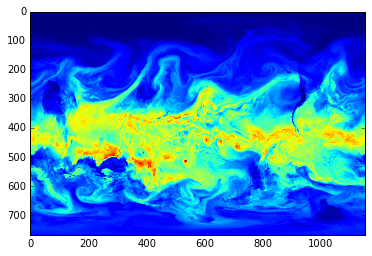

In [32]:
plt.imshow(tmq_one_time_step)

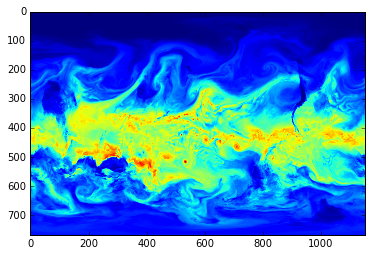

In [33]:
#second time step
plt.imshow(root['TMQ'][1])

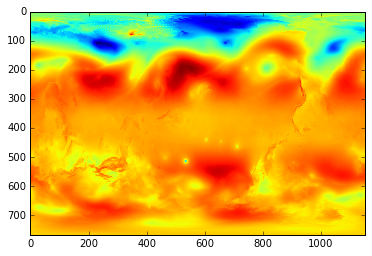

In [35]:
plt.imshow(root['PSL'][0])

## Ok, so those are the images, now let's transform them into spatiotemporal patches

In [36]:
variables_of_interest = [u'PRECT',
 u'PS',
 u'PSL',
 u'QREFHT',
 u'T200',
 u'T500',
 u'TMQ',
 u'TREFHT',
 u'TS',
 u'U850',
 u'UBOT',
 u'V850',
 u'VBOT',
 u'Z1000',
 u'Z200',
 u'ZBOT']

In [47]:
def make_time_slice(dataset, time, variables, x=768, y=1152):
    variables_at_time_slice = [dataset[k][time] for k in variables]
    tensor = np.vstack(variables_at_time_slice).reshape(len(variables), x,y)
    return tensor
    

In [48]:
time0 = make_time_slice(root, time=0, variables=variables_of_interest)

In [49]:
time0.shape

(16, 768, 1152)

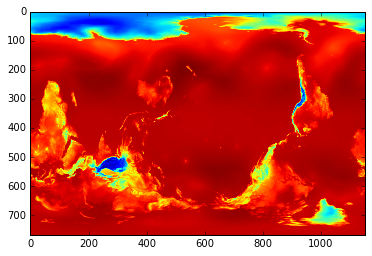

In [50]:
#let's check and see if we're good here
plt.imshow(time0[1])

## Ok so that is all the variables for one slice in time. Now let's make a tensor for every time slice

In [51]:
def make_spatiotemporal_tensor(dataset,num_time_slices, variables, x=768, y=1152):
    time_slices = [ make_time_slice(dataset, time, variables) for time in range(num_time_slices) ]
    tensor = np.vstack(time_slices).reshape(num_time_slices, len(variables), x, y)
    return tensor

In [53]:
spt_tensor = make_spatiotemporal_tensor(root, len(root['time']), variables_of_interest)

Ok, let's check the shape

In [55]:
spt_tensor.shape

(8, 16, 768, 1152)

Looks good

# at the third time step and the UBOT looks like:

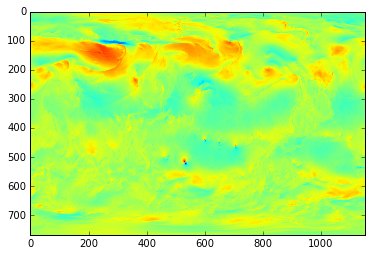

In [60]:
plt.imshow(spt_tensor[3][variables_of_interest.index('UBOT')])

Ok let's add boxes

So every other time step has labels and there can be up to 10 labels. So due to weird caffe annoying things, the label variables are always (8,10) -> for every time step, there are 10 slots, but not all of them are filled, so there is a mask to help you 

In [63]:
mask =root['teca_mask'][:]

In [64]:
print mask

[[1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [72]:
bool_mask = mask == 1

So here we get all phenomena for each time steP

In [80]:
root['teca_xmax'][:, bool_mask[0]]

array([[564, 725, 664, 616],
       [  0,   0,   0,   0],
       [561, 723, 663, 614],
       [  0,   0,   0,   0],
       [555, 717, 656, 606],
       [  0,   0,   0,   0],
       [562, 714, 654, 607],
       [  0,   0,   0,   0]], dtype=int32)

In [117]:
def get_boxes_for_given_time_slice(dataset, time_ind):
    '''given a dataset and a time index, returns a tuple for 
    each clinate event where each tuple is (xmin,xmax,ymin,ymax,category)'''
    mask = dataset['teca_mask'][:] == 1
    xmins, xmaxes, ymins, ymaxes, categories = [list(dataset[k][:,mask[0]][time_ind]) for k in [ u'teca_xmin',
                                                                                 u'teca_xmax',
                                                                                 u'teca_ymin',
                                                                                 u'teca_ymax',
                                                                                 u'teca_category']]
    if not all(xmins) and not all(xmaxes):
        print "No boxes for this time step!"
    return zip(xmins, xmaxes, ymins, ymaxes, categories)
    

In [100]:
get_boxes_for_given_time_slice(root,2)

[(503, 561, 489, 547, 3),
 (691, 723, 448, 480, 0),
 (639, 663, 436, 460, 0),
 (588, 614, 429, 455, 1)]

In [29]:
from matplotlib import patches

def add_bbox(subplot,bbox):
    colors = ['r','g', 'b', 'y', 'k']
    xmin,xmax,ymin, ymax, category = bbox
    subplot.add_patch(patches.Rectangle(
    xy=(xmin,ymin),
    width=xmax - xmin,
    height=ymax - ymin,
    fill=False, color=colors[category]))

def plot_box(dataset, time_slice, variable):
    '''given a dataset, time slice and variable
    it will plot the 2D spatio-temporal-variable slice with the box'''
    im = dataset[variable][time_slice]
    boxes = get_boxes_for_given_time_slice(dataset, time_slice)
    f,sp = plt.subplots()
    sp.imshow(im)
    for box in boxes:
        add_bbox(sp,box)
    plt.show()
    

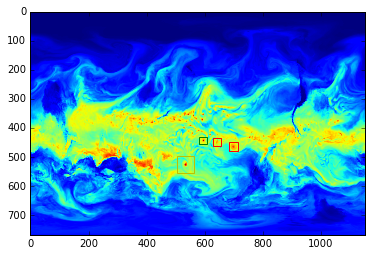

In [130]:
plot_box(root,6, 'TMQ')

# TL;DR

1. RUN THE CELLS BELOW
2. Pick a string from the list variables_of_interest, call it variable
3. Pick a number between 0 and 7, call it time
4. Pick a month in 2 digit form as a string ie March is '03'
5. Pick a day in 2 digit form, ie the 28th is '28', the 1st is '01'
6. Call the function plot(month, day, time, variable)
7. Look at the cool plot


In [34]:
import netCDF4 as nc
from os import listdir, system
from os.path import isfile, join, isdir
import re
import numpy as np

In [35]:
from matplotlib import pyplot as plt

%matplotlib inline

In [36]:
# this directory can be accessed from cori
maindir="/project/projectdirs/dasrepo/gordon_bell/climate/data/big_images/1979"
lsdir=listdir(maindir)

rpfile = re.compile(r"^cam5_.*\.nc$")
camfiles = [f for f in lsdir if rpfile.match(f)]

In [37]:
random_file = camfiles[22]

root = nc.Dataset(maindir+'/'+random_file, "r", format="NETCDF4")

In [38]:
prefix = 'cam5_1_amip_run2.cam2.h2.1979'
suffix = '00000.nc'

In [39]:
variables_of_interest = [u'PRECT',
 u'PS',
 u'PSL',
 u'QREFHT',
 u'T200',
 u'T500',
 u'TMQ',
 u'TREFHT',
 u'TS',
 u'U850',
 u'UBOT',
 u'V850',
 u'VBOT',
 u'Z1000',
 u'Z200',
 u'ZBOT']

In [40]:
def get_boxes_for_given_time_slice(dataset, time_ind):
    '''given a dataset and a time index, returns a tuple for 
    each clinate event where each tuple is (xmin,xmax,ymin,ymax,category)'''
    mask = dataset['teca_mask'][:] == 1
    xmins, xmaxes, ymins, ymaxes, categories = [list(dataset[k][:,mask[0]][time_ind]) for k in [ u'teca_xmin',
                                                                                 u'teca_xmax',
                                                                                 u'teca_ymin',
                                                                                 u'teca_ymax',
                                                                                 u'teca_category']]
    if not all(xmins) and not all(xmaxes):
        print "No boxes for this time step!"
    return zip(xmins, xmaxes, ymins, ymaxes, categories)

In [41]:
from matplotlib import patches

def add_bbox(subplot,bbox):
    colors = ['r','g', 'b', 'y', 'k']
    xmin,xmax,ymin, ymax, category = bbox
    subplot.add_patch(patches.Rectangle(
    xy=(xmin,ymin),
    width=xmax - xmin,
    height=ymax - ymin,
    fill=False, color=colors[category]))

def plot_box(dataset, time_slice, variable):
    '''given a dataset, time slice and variable
    it will plot the 2D spatio-temporal-variable slice with the box'''
    im = dataset[variable][time_slice]
    boxes = get_boxes_for_given_time_slice(dataset, time_slice)
    f,sp = plt.subplots()
    sp.imshow(im)
    for box in boxes:
        add_bbox(sp,box)
    plt.show()
    
def plot(month='05',day='05',time=0,variable='TMQ'):
    filename = '-'.join([prefix,month,day,suffix])
    print filename
    dataset = nc.Dataset(maindir+'/'+ filename, "r", format="NETCDF4")
    plot_box(dataset, time, variable)
    

cam5_1_amip_run2.cam2.h2.1979-08-30-00000.nc


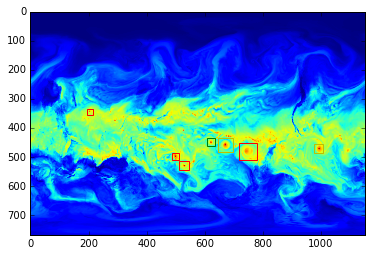

In [42]:
plot(month='08', day='30', time=0, variable='TMQ')